<a href="https://colab.research.google.com/github/SebastianEcheverryL/Machine-Learning-InceptionV3-with-Tensorflow/blob/main/ProjectDSPCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CNN MODEL

The first step was to download and import the libraries that are necessary to realize the CNN model. In this case we don't create a directory inside Drive, but we manage directly the GitHub address where the data is hosted, this by Kaggle's recommendation.

In [ ]:
import keras
import kagglehub
import numpy as np
import seaborn as sns
import sklearn.metrics as skm
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import datasets, layers, models, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, accuracy_score, recall_score, confusion_matrix
!pip install pydot graphviz
from tensorflow.keras.utils import plot_model

In [ ]:
# Download latest version from GitHub of Kaggle

path = kagglehub.dataset_download("rizwan123456789/potato-disease-leaf-datasetpld")
path_base = path + '/PLD_3_Classes_256'
path_train = path_base + '/Training'
path_val = path_base + '/Validation'
path_test = path_base + '/Testing'

100%|██████████| 37.4M/37.4M [00:03<00:00, 12.4MB/s]

Extracting files...


Next, the ImageDataCreator function is used to perform a digital preprocessing of the images in order to ensure correct machine learning. First the image is divided by 255 to normalize it and ensure that the value of each pixel is between 0-1.

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

validation_datagen = ImageDataGenerator(rescale=1./255)

Next, the parameters of the image generators are configured. The direction where the generator will take the images is configured. The number of images per batch, the training generator has more images per batch, because the number of images is higher. Also a resizing of 150x150 is done, this in order to reduce the computational cost, but it cannot be reduced much because the quality of the images worsens a lot. And we choose the mode used by the generator, in this case as we have 3 classes we must use a categorical mode.

In [ ]:
train_generator = train_datagen.flow_from_directory(
        path_train, # the directory where the training images are located
        target_size=(150, 150), # resize all images to 150x150
        batch_size=50, # Number of images per batch
        class_mode='categorical' # Classification for multiple classes
)

test_generator = test_datagen.flow_from_directory(
        path_test, # the directory where the test images are located
        target_size=(150, 150), # Resize all images to 150x150
        batch_size=10, # Number of images per batch
        class_mode='categorical' # Classification for multiple classes
)

validation_generator = validation_datagen.flow_from_directory(
        path_val, # the directory where the validation images are located
        target_size=(150, 150), # Resize all the images to 150x150
        batch_size=10, # Number of images per batch
        class_mode='categorical' # Classification for multiple classes
)

Found 3251 images belonging to 3 classes.
Found 405 images belonging to 3 classes.
Found 416 images belonging to 3 classes.


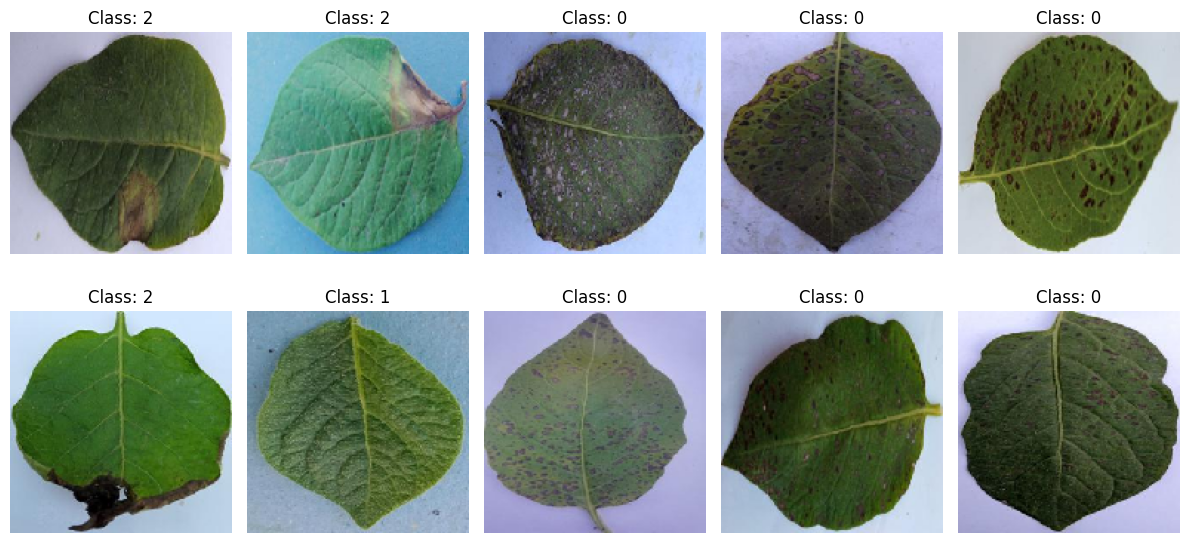

In [ ]:
# Get a batch of images and labels
images, labels = next(train_generator)

# Display the images in the batch
fig, axes = plt.subplots(2, 5, figsize=(12, 6)) # Create a 2x4 grid
axes = axes.flatten()

for img, label, ax in zip(images, labels, axes):
    ax.imshow(img) # Show the image.
    ax.axis('off') # Remove the axes
    ax.set_title(f"Class: {label.argmax()}") # Show class label

plt.tight_layout()
plt.show()


Then the convolutional model is created with 4 stages, each stage is assigned a MaxPooling with a size of 2x2, this to improve the performance of the machine and avoid generating excessive trainable parameters increasing the risk of overfitting. The first stage has 64 output feature maps, the second stage has 64 maps, the third stage has 128 and the last stage has 256 feature maps. All the stages have 3x3 mask sizes and padding of “same” value, since within the simulations it had the best result in the validation accuracy.
At the end a dense network of two stages is created, one of 256 nodes and the other of 3, since they are the number of classes of the applications, that is why “softmax” is used and not another activation. In most of the stages a “ReLu” activation function is used to reduce the computational cost.

In [ ]:
model = models.Sequential()
model.add(Input(shape=(150, 150, 3)))  # Define the input explicitly
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(3, activation='softmax')) # Outlet layer

# Assuming you already have a model created (e.g. model)
plot_model(
    model, # Your Keras model
    to_file='model_architecture.png', # File where the plot will be stored
    show_shapes=True, # Show dimensions of inputs and outputs
    show_layer_names=True, # Show layer names
    expand_nested=True, # Expand nested models if any
    dpi=96 # Image resolution
)

from IPython.display import Image

Image('model_architecture.png')

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 75, 75, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 37, 37, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 20736)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │       5,308,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,717,187 (21.81 MB)

 Trainable params: 5,717,187 (21.81 MB)

 Non-trainable params: 0 (0.00 B)

In this section 3 different processes are carried out: Compilation, Training and Evaluation.
In the compilation stage it is defined which optimizer will be used, which type of mode will be used depending on the number of classes and the desired metrics.
In the training stage, the images generated by the training generator are entered and validated with the test images.
Finally, the learning of the model is evaluated with the validation set.

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_generator, epochs=25, validation_data=test_generator)


test_loss, test_acc = model.evaluate(validation_generator, steps=len(validation_generator))
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


66/66 ━━━━━━━━━━━━━━━━━━━━ 16s 115ms/step - accuracy: 0.3875 - loss: 1.0872 - val_accuracy: 0.5753 - val_loss: 0.9025
Epoch 2/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.6307 - loss: 0.8193 - val_accuracy: 0.6889 - val_loss: 0.7398
Epoch 3/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.7693 - loss: 0.6059 - val_accuracy: 0.7309 - val_loss: 0.7879
Epoch 4/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.8571 - loss: 0.4069 - val_accuracy: 0.8889 - val_loss: 0.2868
Epoch 5/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.8949 - loss: 0.2829 - val_accuracy: 0.8765 - val_loss: 0.3274
Epoch 6/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9153 - loss: 0.2387 - val_accuracy: 0.9160 - val_loss: 0.2251
Epoch 7/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.9489 - loss: 0.1569 - val_accuracy: 0.9457 - val_loss: 0.1602
Epoch 8/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.9464 - loss: 0.1339 - val_accuracy: 0.9481 - val_loss: 

Losses and accuracy are evaluated by time. Twenty-five epochs were chosen because it presents the best learning with less time and computational resources.

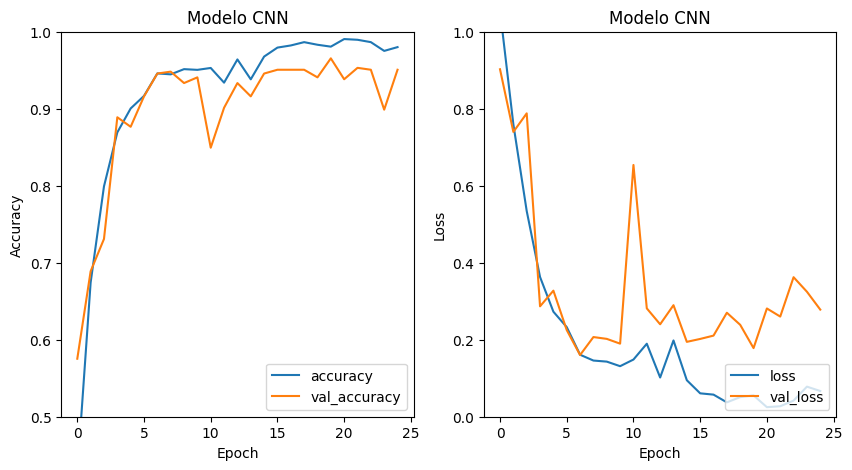

In [ ]:
# The learning curves of the CNN model are calculated and plotted:

plt.figure(figsize=(10,5))

#Accuracy curve
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.title('Modelo CNN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

#Loss curve
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.title('Modelo CNN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.0, 1])
plt.legend(loc='lower right')

Finally, the confusion matrix and the accuracy and recall report are performed by predicting the model.

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step


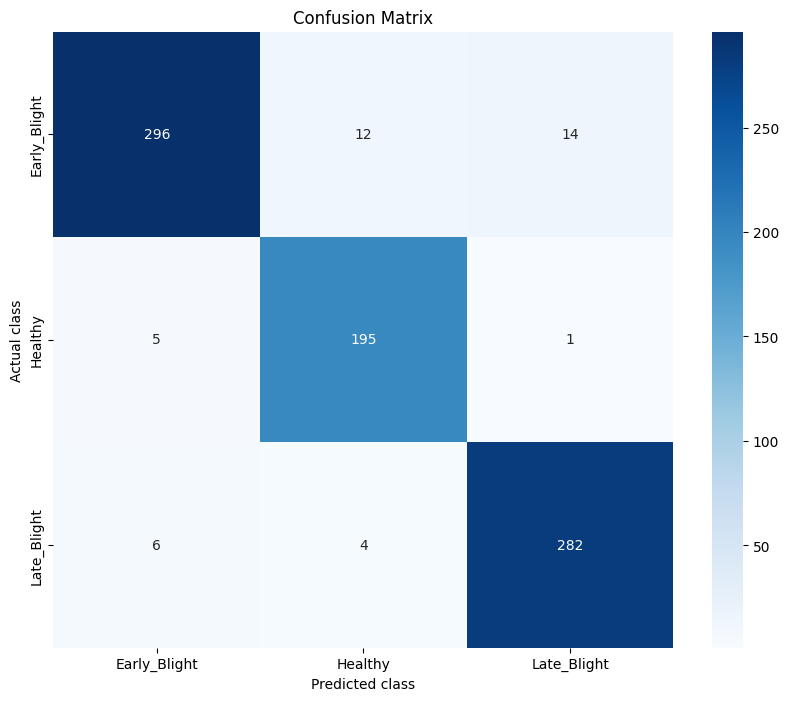

Classification report:
              precision    recall  f1-score   support

Early_Blight       0.96      0.92      0.94       322
     Healthy       0.92      0.97      0.95       201
 Late_Blight       0.95      0.97      0.96       292

    accuracy                           0.95       815
   macro avg       0.95      0.95      0.95       815
weighted avg       0.95      0.95      0.95       815



In [ ]:
# Initialize lists for storing images and tags
all_images = []
all_labels = []

# Iterate through all generator batches.
for i in range(len(test_generator)):
    images_test, labels_test = next(test_generator) # Get a batch.
    images_validation, labels_validation = next(validation_generator) # Get a batch
    all_images.append(images_test) # Add images from batch
    all_labels.append(labels_test) # Add labels from batch
    all_images.append(images_validation) # Add images from batch
    all_labels.append(labels_validation) # Add labels from the batch

# Convert lists to arrays
all_images = np.concatenate(all_images)
all_labels = np.concatenate(all_labels)

# Make predictions
predictions = model.predict(all_images)
predicted_labels = np.argmax(predictions, axis=1)

# Get class names
class_names = list(test_generator.class_indices.keys())

# Convert probabilities to predicted labels
true_labels_classes = np.argmax(all_labels, axis=1)

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels_classes, predicted_labels)

# Display the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Confusion Matrix')
plt.show()

# Sort report
print('Classification report:')
print(classification_report(true_labels_classes, predicted_labels, target_names=class_names))